# <center> Solución de la Ecuacíón de Poisson por el Método de Elementos Finitos <center>
## <center> Proyecto Final de Física Computacional <center>
### Fecha de entrega: 20/06/2022

### 1. Descripción del Problema

Aplicar el método de elementos finitos  para resolver la ecuación de Poisson en dos dimensiones.

### 2. Método de Elementos Finitos

Es una técnica numérica utilizada para resolver problemas de ecuaciones diferenciales de valores en la frontera. La idea principal es representar el dominio con un conjunto de subdominios más pequeños llamados *elementos finitos*. Las cantidades dentro del elemento finito se interpolan utilizando vlores en una serie de nodos alrededor del elemento finito, en el caso de utilizar nodos, o utilizando valores en las orillas del elemento finito en el caso que se usen elementos vectorizados. Nosotros sólo nos enfocaremos en el caso de elementos nodales.
La interpolación se realiza mediante la elección de un conjunto de polinomios, que forman una base con la cual se construye un sistema de ecuaciones lineales. La exactitud de solución numérica depende del orden de los polinomios escogidos, del número de nodos y el número de elementos.
Para formar dicho sistema de ecuaciones, la ecuación diferencial debe primero transformarse en una ecuación integral-diferencial *(formulación débil)* que se resuelve al minimizar un funcional *(Método de Rayleight-Ritz)*, o utilizando el *Método de Residuo Ponderado de Galerking* que es en el que nos enfocaremos.

Loa pasos principales para la aplicación del método de Galerkin MEF para la solución de problenmas de valores en la frontera son:

* Discretizar el dominio utilizando elementos finitos.
* Escoger funciones de interpolación apropiadas (base de polinomios).
* Obtener las ecuaciones lineales correspondientes a un solo elemento finito mediante la formulación débil.
* Imponer las condiciones de frontera de Dirichlet.
* Resolver el sistema de ecuaciones lineales mediante técnicas de álgebra lineal.
* Postprocesar los resultados.

### 3. Ecuación de Poisson en 1D 

Aplicaremos el método de elementos finitos a un problema electrostático con condiciones de frontera en una dimensión para ejemplificar el uso del método de elementos finitos y los pasos a seguir.


**Problema en 1D:** Considere dos placas conductoras infinitas paralelas que se posicionan perpendicularmente al eje $x$ y separadas por una distancia $d$, como se muestra en la figura. Una placa tiene un potencial eléctrico constante $V = V_0$ y la otra un potencial $V = 0$. La region entre las placas está llena de un medio no magnético con una constante dieléctrica relativa $\varepsilon_{r}$ y una densidad volumétrica $\rho_{v} = -\rho_{0}$. Obtener las soluciones analítica y por elementos finitos para el potencial eléctrico en la región comprendida entre las dos placas.

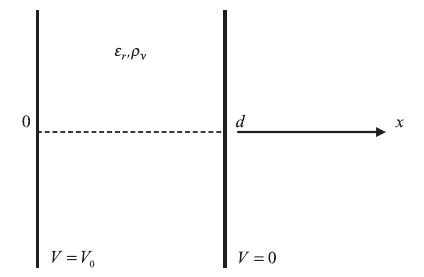

**Solución Analítica**

El potencial eléctrico está governado por la ecuación de Poisson
$$\nabla(\varepsilon_{r}\nabla V) = -\frac{\rho_{v}}{\varepsilon_{0}}$$

Condiciones de frontera:
$$V(0) = V_{0}$$
$$V(0) = V_{0}$$

Para un medio homogéneo y lineal en una dimensión, escribimos la ecuación de Poisson como
$$\frac{d^{2}V}{dx^{2}} = \frac{\rho_{0}}{\varepsilon_{r}\varepsilon_{0}}$$

donde $\rho_{v} = -\rho_{0}$. Integrando dos veces se obtiene
$$ V(x) = \frac{\rho_{0}}{2\varepsilon_{r}\varepsilon_{0}}x^{2} + c_{1}x + c_{0}$$

donde $c_{1}$ y $c_{0}$ son constantes que se determinan mediante las condiciones de frontera *(condiciones de Dirichlet)*. Así se obtiene
$$ V(x) = \frac{\rho_{0}}{2\varepsilon_{r}\varepsilon_{0}}x^{2} - \left(\frac{\rho_{0}d}{2\varepsilon_{r}\varepsilon_{0}} + \frac{V_{0}}{d}\right)x + V_{0}$$

**Solución FEM**

Este problema corresponde a una línea recta en el eje $x$. Se discretiza este dominio dividiendolo en $N_{e}$ elementos finitos y $N_{n}$ nodos. Los elementos que se muestran en la figura están encerrados en un circulo.

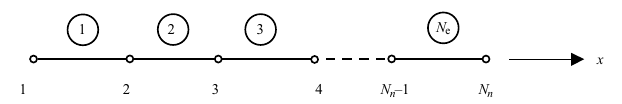

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['text.usetex'] = True  # Render pyplot text as LaTeX
plt.rc('figure', titlesize=18)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=15)

In [2]:
# Parameters for analytical solution
e0 = 8.85e-12       # F/m
er = 1              # Relative permittivity
e = er*e0
V0 = 1              # V
d = 8e-2            # m  (8 cm)
rho0 = 1e-8         # C/m

In [3]:
NoN = 5             # Number of Nodes
NoE = NoN - 1       # Number of Elements

xn = np.linspace(0, d, NoN)
yn = np.zeros(NoN)

NL = np.array([xn, yn]).T
EL = np.zeros([NoE, 2]).astype('int64')

for j in range(2):
    for i in range(NoE):
        EL[i,j] = i + j + 1


print('Node list \n', NL)
print('\n')
print('Element list \n', EL)

Node list 
 [[0.   0.  ]
 [0.02 0.  ]
 [0.04 0.  ]
 [0.06 0.  ]
 [0.08 0.  ]]


Element list 
 [[1 2]
 [2 3]
 [3 4]
 [4 5]]


Se escoge la base (polinomios) para representar el potencial en los nodos como una combinación lineal

$$V = \sum_{j=1}^{n}v_{j}^{e}N_{j}(x)$$

donde $v_{j}^{e}$ son los valores de la solución en los nodos del elemento $e$, $N_{j}(x)$ son los polinomios base, y $n$ es el número de nodos en el dominio del elemento. Para un elemento lineal en 1D, $n=2$.

Los polinomios base se escogen de tal manera que $N_{j}(x)$ sea igual a $1$ en el nodo $j$ y $0$ en cualquier otro nodo. Para un elemento con coordenadas $x_{1}^{e}$ y $x_{2}^{e}$, es mas facil lograr esto haciendo un cambio de coordenadas.

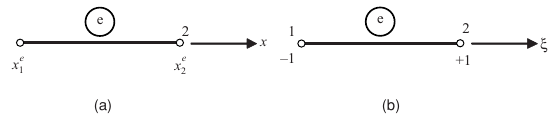

$$\xi = \frac{2(x - x_{1}^{e})}{x_{2}^{e} - x_{1}^{e}} - 1$$


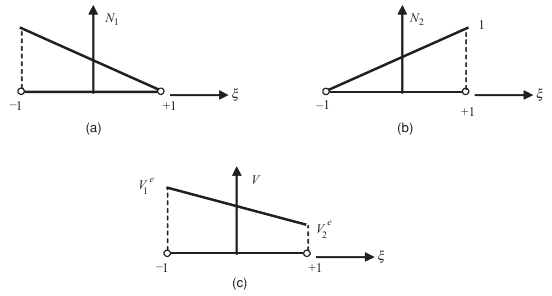

$$N_{1}(\xi) = \frac{1 - \xi}{2}$$

$$N_{2}(\xi) = \frac{1 + \xi}{2}$$

$$V(\xi) = v_{1}^{e}N_{1}(\xi) + v_{2}^{e}N_{2}(\xi)$$

El método de resido ponderado se obtiene moviendo todos los términos de la ecuación diferencial de un lado de la ecuación, multiplicando por una función de ponderación e integrando sobre el dominio del elemento

$$r^{e} = \int_{x_{1}^{e}}^{x_{2}^{e}}w\left[\frac{d}{dx}\left(\varepsilon_{r}^{e} \frac{dV}{dx}\right) + \frac{\rho_{v}}{\varepsilon_{0}}\right]dx$$

$$\int_{x_{1}^{e}}^{x_{2}^{e}}w\left[\frac{d}{dx}\left(\varepsilon_{r}^{e} \frac{dV}{dx}\right) + \frac{\rho_{v}}{\varepsilon_{0}}\right]dx = 0$$

$$\varepsilon^{e} = \varepsilon_{r}^{e}\varepsilon_{0}$$

Como vamos a usar funciones base lineales y no de ordenes superiores, usamos integración por partes para deshacernos de la segunda derivada.

$$\int_{a}^{b}UdV = UV\Big|_{a}^{b} - \int_{a}^{b}VdU$$


$$
\begin{align*}
\int_{x_{1}^{e}}^{x_{2}^{e}}w\frac{d}{dx}\left(\varepsilon^{e} \frac{dV}{dx}\right)dx &= \int_{x_{1}^{e}}^{x_{2}^{e}}w\left(\varepsilon^{e} \frac{dV}{dx}\right)dx \\
&= w\varepsilon^{e} \frac{dV}{dx}\Big|_{x_{1}^{e}}^{x_{2}^{e}} - 
\int_{x_{1}^{e}}^{x_{2}^{e}}\frac{dw}{dx}\left(\varepsilon^{e} \frac{dV}{dx}\right)dx
\end{align*}
$$

La formulación débil de la ecuación diferencial se expresa como

$$
\int_{x_{1}^{e}}^{x_{2}^{e}}\frac{dw}{dx}\left(\varepsilon^{e} \frac{dV}{dx}\right)dx - 
\int_{x_{1}^{e}}^{x_{2}^{e}}w\rho_{0}dx - 
w\varepsilon^{e} \frac{dV}{dx}\Big|_{x_{1}^{e}}^{x_{2}^{e}} = 0
$$

$$
\begin{align*}
w\varepsilon^{e} \frac{dV}{dx}\Big|_{x_{1}^{e}}^{x_{2}^{e}} =
w(x_{2}^{e})\left[\varepsilon^{e}\frac{dV}{dx}\right]_{x=x_{2}^{e}} - 
w(x_{1}^{e})\left[\varepsilon^{e}\frac{dV}{dx}\right]_{x=x_{1}^{e}}
\end{align*}
$$

$$
D_{x}^{e} = -\varepsilon^{e}\frac{dV}{dx}
$$

$$
w\varepsilon^{e} \frac{dV}{dx}\Big|_{x_{1}^{e}}^{x_{2}^{e}} =
- w(x_{2}^{e})D_{x}^{e}(x_{2}^{e}) + w(x_{1}^{e})D_{x}^{e}(x_{1}^{e})
$$

reemplazando

$$
\int_{x_{1}^{e}}^{x_{2}^{e}}\frac{dw}{dx}\left(\varepsilon^{e} \frac{dV}{dx}\right)dx - 
\int_{x_{1}^{e}}^{x_{2}^{e}}w\rho_{0}dx - 
- w(x_{2}^{e})D_{x}^{e}(x_{2}^{e}) + w(x_{1}^{e})D_{x}^{e}(x_{1}^{e}) = 0
$$

En el método de residuos de Galerkin se pueden utilizar los polinomios base $N$ como identicas a las funciones de ponderación $w$. Al mismo tiempo sustituimos $V = \sum_{j=1}^{n}v_{j}^{e}N_{j}(x)$, y se obtienen, pa un elemento con $n=2$ nodos:

$$
\int_{x_{1}^{e}}^{x_{2}^{e}}\left(\frac{dN_1}{dx}\right)\varepsilon^{e}\left(\sum_{j=1}^{2}v_{j} \frac{dN_j}{dx}\right)dx = 
\int_{x_{1}^{e}}^{x_{2}^{e}}N_1\rho_{v}dx - 
- N_1(x_{2}^{e})D_{x}^{e}(x_{2}^{e}) + N_1(x_{1}^{e})D_{x}^{e}(x_{1}^{e})
$$

$$
\int_{x_{1}^{e}}^{x_{2}^{e}}\left(\frac{dN_2}{dx}\right)\varepsilon^{e}\left(\sum_{j=1}^{2}v_{j}\frac{dN_j}{dx}\right)dx = 
\int_{x_{1}^{e}}^{x_{2}^{e}}N_2\rho_{v}dx - 
- N_2(x_{2}^{e})D_{x}^{e}(x_{2}^{e}) + N_2(x_{1}^{e})D_{x}^{e}(x_{1}^{e})
$$

pero por las propiedades de las funciones base
$$
\begin{align*}
N_1(x_{1}^{e}) &= 1\\
N_2(x_{1}^{e}) &= 0\\
N_1(x_{2}^{e}) &= 0\\
N_2(x_{2}^{e}) &= 1\\
\end{align*}
$$

$$
\int_{x_{1}^{e}}^{x_{2}^{e}}\left(\frac{dN_1}{dx}\right)\varepsilon^{e}\left(\sum_{j=1}^{2}v_{j} \frac{dN_j}{dx}\right)dx = 
\int_{x_{1}^{e}}^{x_{2}^{e}}N_1\rho_{v}dx  
+ D_{x}^{e}(x_{1}^{e})
$$

$$
\int_{x_{1}^{e}}^{x_{2}^{e}}\left(\frac{dN_2}{dx}\right)\varepsilon^{e}\left(\sum_{j=1}^{2}v_{j}\frac{dN_j}{dx}\right)dx = 
\int_{x_{1}^{e}}^{x_{2}^{e}}N_2\rho_{v}dx  
- D_{x}^{e}(x_{2}^{e})
$$

Estas ecuaciones se pueden escribir en la forma matricial

$$
\left[\begin{matrix}
K_{11}^{e} & K_{12}^{e}\\
K_{21}^{e} & K_{22}^{e}
\end{matrix}\right]
\left[\begin{matrix}
v_{1}^{e} \\ v_{2}^{e}
\end{matrix}\right] = 
\left[\begin{matrix}
f_{1}^{e} \\ f_{2}^{e}
\end{matrix}\right] +
\left[\begin{matrix}
D_{1}^{e} \\ -D_{2}^{e}
\end{matrix}\right]
$$

donde 

$$
K_{ij}^{e} = \int_{x_{1}^{e}}^{x_{2}^{e}}\left(\frac{dN_2}{dx}\right)\varepsilon^{e}\left(\frac{dN_j}{dx}\right)dx
$$

y

$$
f_{i}^{e} = \int_{x_{1}^{e}}^{x_{2}^{e}}N_i\rho_{v}dx
$$

para $i=1,2$ y $j=1,2$.

Aplicamos el cambio de coordenadas que definimos anteriormente

$$d\xi = \frac{2}{x_{2}^{e}-x_{1}^{e}}dx = \frac{2}{l^{e}}dx$$

$$dx = \frac{l^{e}}{2}d\xi$$

$$\frac{dN_i}{dx} = \frac{dN_i}{d\xi}\frac{d\xi}{dx} = \frac{2}{l^{e}}\frac{dN_i}{d\xi}$$

Asi los elementos de la matriz $K_{ij}^{e}$ pueden ser escritos como

$$
\begin{align*}
K_{ij}^{e} &= \int_{-1}^{+1}\left(\frac{2}{l^{e}}\frac{dN_i}{d\xi}\right)\varepsilon^{e}\left(\frac{2}{l^{e}}\frac{dN_j}{d\xi}\right)\frac{l^{e}}{2}d\xi\\
&= \frac{2\varepsilon^{e}}{l^{e}}\int_{-1}^{+1}\frac{dN_i}{d\xi}\frac{dN_j}{d\xi}d\xi , \quad i,j = 1,2
\end{align*}
$$

$$N_{1}(\xi) = \frac{1 - \xi}{2}$$
$$\frac{dN_1}{d\xi} = -\frac{1}{2}$$

$$N_{2}(\xi) = \frac{1 + \xi}{2}$$
$$\frac{dN_2}{d\xi} = +\frac{1}{2}$$

Como resultado los elementos de $K^{e}$ estan dados por

$$K^{e} = \frac{\varepsilon^{e}}{l^{e}}\left[\begin{matrix}
+1 & -1\\
-1 & +1
\end{matrix}\right]$$

Resolvemos las integrales para $f_{i}^{e}$
$$
f_{i}^{e} = \int_{x_{1}^{e}}^{x_{2}^{e}}N_i\rho_{v}dx
$$

$$f_{1}^{e} = - \frac{l^e \rho_0}{2}$$
$$f_{2}^{e} = - \frac{l^e \rho_0}{2}$$

$$f^{e} = - \frac{l^e \rho_0}{2}\left[\begin{matrix}
1 \\ 1
\end{matrix}\right]$$

Para un único elemento se tiene el siguiente sistema matricial

$$
\frac{\varepsilon^{e}}{l^{e}}\left[\begin{matrix}
+1 & -1\\
-1 & +1
\end{matrix}\right]
\left[\begin{matrix}
v_{1}^{e} \\ v_{2}^{e}
\end{matrix}\right] = 
- \frac{l^e \rho_0}{2}\left[\begin{matrix}
1 \\ 1
\end{matrix}\right] +
\left[\begin{matrix}
D_{1}^{e} \\ -D_{2}^{e}
\end{matrix}\right]
$$

**Ensamblaje del sistema con todos los elementos**

Para cada elemento se tiene
$$K_{11}^{e}v_{1}^{e} + K_{12}^{e}v_{2}^{e} = f_{1}^{e} + D_{1}^{e}$$
$$K_{11}^{e}v_{1}^{e} + K_{12}^{e}v_{2}^{e} = f_{2}^{e} + D_{2}^{e}$$

Recodamos que cada elemento está conectado y comparten nodos, por ejemplo el nodo $2$ del elemento $e$ es el nodo $1$ del elemento $e+1$, de manera que las soluciones por cada nodo estan conectadas:

$$v_{2}^{e} = v_{1}^{e+1}$$

Las ecuaciones algebraicas que se obtienen se pueden escribir mas convenientemente en una forma matricial:

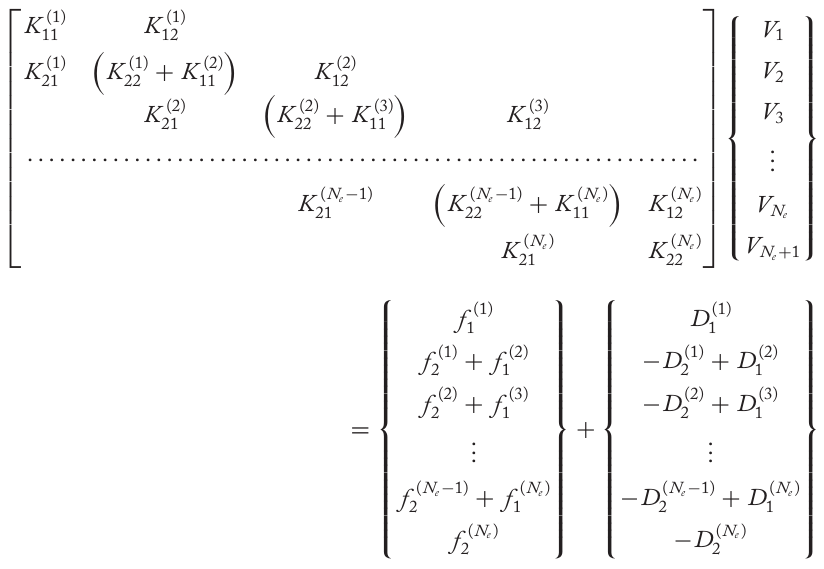

El segundo vector en el miembro derecho, denotado como $d$ representa el desplazamiento electrico en los nodos. 

$$-D_{2}^{(1)} + D_{1}^{(2)} = \varepsilon^{(1)}\frac{dV}{dx}\Big|_{x=x_2^{(1)}} - \varepsilon^{(2)}\frac{dV}{dx}\Big|_{x=x_1^{(2)}} \neq 0
$$

La contribución del vector desplazamiento eléctrico $D$ sería cero para todos los nodos excepto para el nodo inicial y final, de tratarse de la solución exacta. Pero para un numero suficientemente grande de elementos se pueden tomar las contribuciones de $d$ como iguales a cero en forma de aproximación. asi el sistema a resolver tiene la siguiente forma

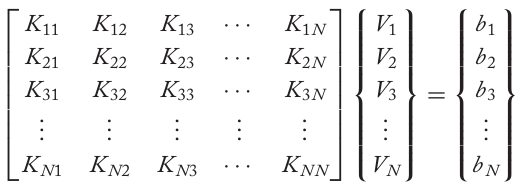

**Ensamblaje del sistema matricial**

In [4]:
K = np.zeros([NoN, NoN])
f = np.zeros(NoN)
le = np.zeros(NoE)

for i in range(NoE):
    le[i] = xn[EL[i,1]-1] - xn[EL[i,0]-1]
    
#Global Assembly
for i in range(NoE):
    #Stiffness matrix
    K[EL[i,0]-1, EL[i,0]-1] = K[EL[i,0]-1, EL[i,0]-1] + e/le[i]
    K[EL[i,0]-1, EL[i,1]-1] = K[EL[i,0]-1, EL[i,1]-1] - e/le[i]
    K[EL[i,1]-1, EL[i,0]-1] = K[EL[i,1]-1, EL[i,0]-1] - e/le[i]
    K[EL[i,1]-1, EL[i,1]-1] = K[EL[i,1]-1, EL[i,1]-1] + e/le[i]
    #force vector
    f[EL[i,0]-1] = f[EL[i,0]-1] - le[i]*rho0/2
    f[EL[i,1]-1] = f[EL[i,1]-1] - le[i]*rho0/2

print('Stiffness matrix')    
print(K)
print('\n')
print('Voltage vector') 
print(f)

Stiffness matrix
[[ 4.425e-10 -4.425e-10  0.000e+00  0.000e+00  0.000e+00]
 [-4.425e-10  8.850e-10 -4.425e-10  0.000e+00  0.000e+00]
 [ 0.000e+00 -4.425e-10  8.850e-10 -4.425e-10  0.000e+00]
 [ 0.000e+00  0.000e+00 -4.425e-10  8.850e-10 -4.425e-10]
 [ 0.000e+00  0.000e+00  0.000e+00 -4.425e-10  4.425e-10]]


Voltage vector
[-1.e-10 -2.e-10 -2.e-10 -2.e-10 -1.e-10]


**Condiciones de frontera**

Se imponen haciendo que el resultado para la primera fila y la ultima de la matriz $K$ sean cero, excepto los valores en los extremos que deben cer iguales a 1.

In [5]:
#Boundary conditions
# first node
K[0,0] = 1
f[0] = V0
for i in range(1,NoN):
    K[0,i] = 0
    
# last node    
K[NoN -1,NoN -1] = 1
f[NoN -1] = 0
for i in range(NoN -1):
    K[NoN-1,i] = 0
    
print('Stiffness matrix')    
print(K)
print('\n')
print('Voltage vector') 
print(f)

Stiffness matrix
[[ 1.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [-4.425e-10  8.850e-10 -4.425e-10  0.000e+00  0.000e+00]
 [ 0.000e+00 -4.425e-10  8.850e-10 -4.425e-10  0.000e+00]
 [ 0.000e+00  0.000e+00 -4.425e-10  8.850e-10 -4.425e-10]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  1.000e+00]]


Voltage vector
[ 1.e+00 -2.e-10 -2.e-10 -2.e-10  0.e+00]


In [6]:
V_sol = np.linalg.solve(K,f)

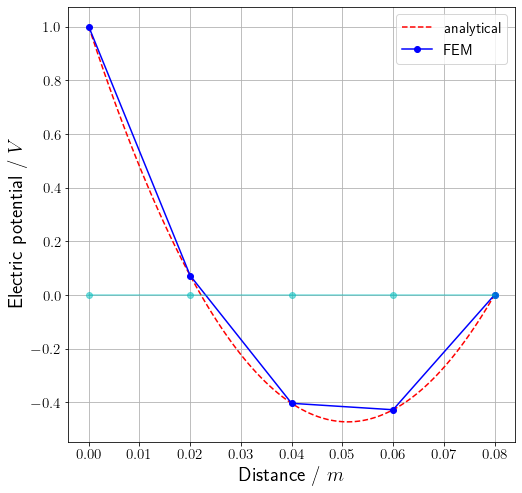

In [7]:
x = np.linspace(0, d, 100)
V = (rho0/(2*er*e0))*np.power(x, 2) - (rho0*d/(2*er*e0) + V0/d)*x + V0

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.plot(x, V, 'r--', label='analytical')
ax.plot(xn, V_sol, 'bo-', label='FEM')
ax.plot(xn, yn, 'co-', alpha=0.5)
ax.grid(True)
ax.set_xlabel(r'Distance / $m$')
ax.set_ylabel(r'Electric potential / $V$')
ax.legend()

### 4. Ecuación de Poisson en 2D

La ecuación de Poisson en 2D para electrostática es un caso especial de la siguiente ecuación:

$$\frac{\partial}{\partial x}\left(\alpha_x\frac{\partial u}{\partial x}\right)
+\frac{\partial}{\partial y}\left(\alpha_y\frac{\partial u}{\partial x}\right)
+\beta u = g
$$

$$\frac{\partial}{\partial x}\left(\varepsilon\frac{\partial V}{\partial x}\right)
+\frac{\partial}{\partial y}\left(\varepsilon\frac{\partial V}{\partial x}\right)
 = -\rho_{v}
$$


La formulación débil del método de Galerkin vendría dada por

$$
\int\int_{\Omega}w\left[
\frac{\partial}{\partial x}\left(\alpha_x\frac{\partial u}{\partial x}\right)
+\frac{\partial}{\partial y}\left(\alpha_y\frac{\partial u}{\partial x}\right)
+\beta u - g \right]dxdy = 0
$$

Aplicando regla de la cadena y separando las integrales se obtiene:

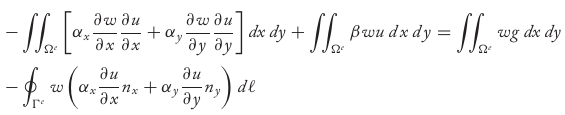

Al ser una ecuación con segunda derivada en 2D, se puede reducir el problema con el toerema de Green y pasando a una forma que solo contiene una sola derivada.

$$
\oint_{\Gamma^e}w\left(\alpha_x\frac{\partial u}{\partial x}n_x + \alpha_y\frac{\partial u}{\partial y}n_y\right)
$$

Como en el caso 1D, se deben escoger funciones base para reemplazar nuestra solución mediante una combinación lineal

$$V = \sum_{j=1}^{n}v_{j}^{e}N_{j}(x,y)$$

$$w = Ni, \quad i=1,2,\dots, n$$


Luego de manipulaciones se llega al siguiente sistema:

$$
\int\int_{\Omega}\left[
\alpha_x\frac{\partial N_i}{\partial x}\left(\sum_{j=1}^{n}\frac{\partial N_j}{\partial x}\right)
+\alpha_y\frac{\partial N_i}{\partial x}\left(\sum_{j=1}^{n}\frac{\partial N_j}{\partial y}\right)
+\beta u - g \right]dxdy =
\int\int_{\Omega}N_i dxdy - \oint_{\Gamma^e}N_i\left(\alpha_x\frac{\partial u}{\partial x}n_x + \alpha_y\frac{\partial u}{\partial y}n_y\right)dl, \quad
i = 12, \ldots,n
$$

Este sistema se puede escribir en forma matricial

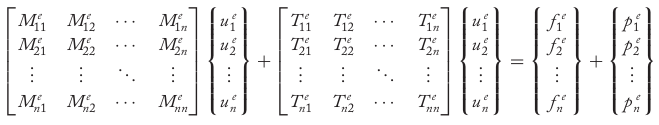

La matriz $T$ para el caso electrostático es cero porque $\beta = 0$, y la matriz $p$ está formada por ceros excepto en el el primer y último elementos, debido a la propiedad de conectividad de los elementos finitos, así que reducimos el sistema a

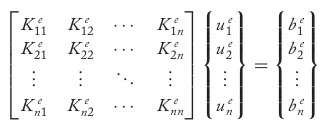

**Discretización**

El dominio usualmente se discretiza utilizando elementos planos rectangulares o triangulares.

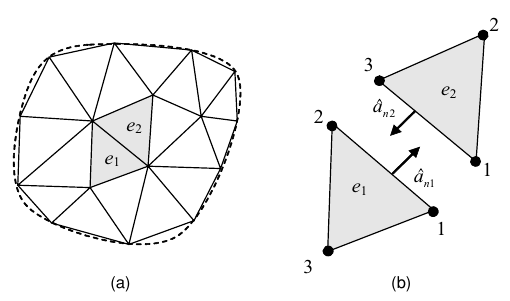

In [8]:
def uniform_mesh(d1, d2, p, m, element_type='D2QU4N'):
    
    # Corners of the mesh
    
    q = np.array([[0, 0], [d1, 0], [0, d2], [d1, d2]])
    PD = 2
    NoN = (p+1)*(m+1)  # Number of Nodes
    
    """
    element_type: D2QU4N
    D2: 2 dimensions
    QU: quadrilateral
    4N: 4 nodes per element
    """
    
    NoE = p*m          # Number of Elements
    NpE = 4            # Nodes per Element
    
    # Generating Nodes
    NL = np.zeros([NoN, PD])
    a = (q[1, 0] - q[0, 0])/p  # Increment in the horizontal direction
    b = (q[2, 1] - q[0, 1])/m  # Increment in the vertical direction
    n = 0  # Counter for rows in NL
    for i in range(1, m+2):
        for j in range(1, p+2):
            NL[n, 0] = q[0, 0] + (j-1)*a  # for x values
            NL[n, 1] = q[0, 1] + (i-1)*b  # for y values
            n += 1
            
    # Generating Elements

    EL = np.zeros([NoE, NpE])

    for i in range(1, m+1):
        for j in range(1, p+1):

            if j == 1:
                EL[(i-1)*p+j-1, 0] = (i-1)*(p+1) + j
                EL[(i-1)*p+j-1, 1] = EL[(i-1)*p+j-1, 0] + 1
                EL[(i-1)*p+j-1, 3] = EL[(i-1)*p+j-1, 0] + (p+1)
                EL[(i-1)*p+j-1, 2] = EL[(i-1)*p+j-1, 3] + 1

            else:
                # second node of previous elment
                EL[(i-1)*p+j-1, 0] = EL[(i-1)*p+j-2, 1]
                # third node of previous elment
                EL[(i-1)*p+j-1, 3] = EL[(i-1)*p+j-2, 2]
                EL[(i-1)*p+j-1, 1] = EL[(i-1)*p+j-1, 0] + 1
                EL[(i-1)*p+j-1, 2] = EL[(i-1)*p+j-1, 3] + 1

    """
     element_type: D2TR3N
         D2: 2 dimensions
         TR: triangular
         3N: 3 nodes per element
    """

    if element_type == 'D2TR3N':

        NoE_tri = 2*NoE        # Number of Elements
        NpE_tri = 3            # Nodes per Element

        # Generating Elements
        EL_tri = np.zeros([NoE_tri, NpE_tri])
        for i in range(1, NoE + 1):             
            # first triangular element             
            EL_tri[2*(i-1), 0] = EL[i-1, 0]             
            EL_tri[2*(i-1), 1] = EL[i-1, 1]             
            EL_tri[2*(i-1), 2] = EL[i-1, 2]
            
            # second triangular element 
            EL_tri[2*(i-1) + 1, 0] = EL[i-1, 0]
            EL_tri[2*(i-1) + 1, 1] = EL[i-1, 2]
            EL_tri[2*(i-1) + 1, 2] = EL[i-1, 3]

        EL = EL_tri

    return NL, EL.astype('int64')

p:8
m:8
Choose element_type
1. Quadrilateral
2. Triangular
elemnt_type: 2


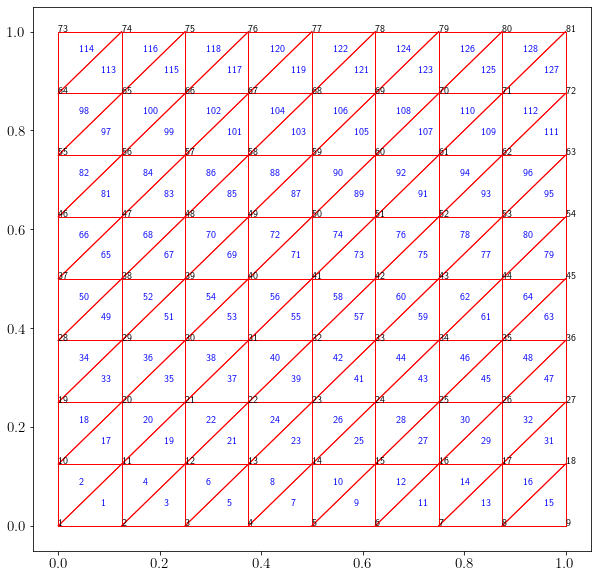

In [9]:
# Parameters for analytical solution
e0 = 8.85e-12       # F/m
er = 1              # Relative permittivity
e = er*e0
V0 = 1              # Initial Voltage
rho0 = 1e-8         # C/m



d1 = 1
d2 = 1
p = int(input("p:"))
m = int(input("m:"))
choose = int(input("Choose element_type\n"
                    "1. Quadrilateral\n"
                    "2. Triangular\n"
                    "elemnt_type: "))
if choose == 1:
    element_type = 'D2QU4N'
elif choose == 2:
    element_type = 'D2TR3N'

NL, EL = uniform_mesh(d1, d2, p, m, element_type)


NoN = np.size(NL, 0)
NoE = np.size(EL, 0)

plt.figure(figsize=(10, 10))

node_counter = 1
for i in range(NoN):
    plt.annotate(node_counter, xy=(NL[i, 0], NL[i, 1]))
    node_counter += 1

if element_type == 'D2QU4N':
    element_counter = 1
    for j in range(NoE):
        plt.annotate(element_counter, xy=((NL[EL[j, 0]-1, 0] + 
                                           NL[EL[j, 1]-1, 0] +
                                           NL[EL[j, 2]-1, 0] +
                                           NL[EL[j, 3]-1, 0])/4,
                                          (NL[EL[j, 0]-1, 1] +
                                           NL[EL[j, 1]-1, 1] +
                                           NL[EL[j, 2]-1, 1] +
                                           NL[EL[j, 3]-1, 1])/4),
                                        color='blue')
        element_counter += 1


    x0 = NL[EL[:, 0]-1, 0]
    y0 = NL[EL[:, 0]-1, 1]
    x1 = NL[EL[:, 1]-1, 0]
    y1 = NL[EL[:, 1]-1, 1]
    x2 = NL[EL[:, 2]-1, 0]
    y2 = NL[EL[:, 2]-1, 1]
    x3 = NL[EL[:, 3]-1, 0]
    y3 = NL[EL[:, 3]-1, 1]

    plt.plot(np.array([x0, x1]), np.array([y0, y1]), 'red', linewidth=1)
    plt.plot(np.array([x1, x2]), np.array([y1, y2]), 'red', linewidth=1)
    plt.plot(np.array([x2, x3]), np.array([y2, y3]), 'red', linewidth=1)
    plt.plot(np.array([x3, x0]), np.array([y3, y0]), 'red', linewidth=1)


elif element_type == 'D2TR3N':
    element_counter = 1
    for j in range(NoE):
        plt.annotate(element_counter, xy=((NL[EL[j, 0]-1, 0] +
                                           NL[EL[j, 1]-1, 0] +
                                           NL[EL[j, 2]-1, 0])/3,
                                          (NL[EL[j, 0]-1, 1] +
                                           NL[EL[j, 1]-1, 1] +
                                           NL[EL[j, 2]-1, 1])/3),
                                        color='blue')
        element_counter += 1

    x0 = NL[EL[:, 0]-1, 0]
    y0 = NL[EL[:, 0]-1, 1]
    x1 = NL[EL[:, 1]-1, 0]
    y1 = NL[EL[:, 1]-1, 1]
    x2 = NL[EL[:, 2]-1, 0]
    y2 = NL[EL[:, 2]-1, 1]
    
    plt.plot(np.array([x0, x1]), np.array([y0, y1]), 'red', linewidth=1)
    plt.plot(np.array([x1, x2]), np.array([y1, y2]), 'red', linewidth=1)
    plt.plot(np.array([x2, x0]), np.array([y2, y0]), 'red', linewidth=1)

**Problema**

Considere una caja rectangular con paredes metálicas infinitas mostrada en la figura. Las paredes verticales y la de abajo se mantienen a un potencial $V = 0$, mientras que la pared de arriba, que está separada por pequeñas aperturas, tiene un potencial fijo $V=V_0$. La región dentro de la caja está libre de carga. Use FEM para resolver la ecuación de Laplace sujeta a las condiciones de frontera dadas para encontrar la distribución del potencial eléctrico dentro de la caja.

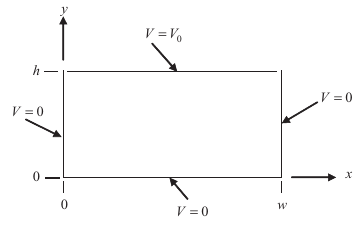

Ecuación de Laplace
$$\frac{\partial^2 V}{\partial^2 x} + \frac{\partial^2 V}{\partial^2 x} = 0$$

Condiciones de frontera
$$
\begin{align*}
V(x,0) &= 0\\
V(x,h) &= V_0\\
V(0,y) &= 0\\
V(w,y) &= 0
\end{align*}
$$

Solución analítica por el método de separación de variables.

$$V(x,y) = \frac{4V_0}{\pi}\sum_{k=1}^{\infty}\frac{\sin \frac{(1k-1)\pi x}{w} \sinh \frac{(1k-1)\pi y}{w}}{(2k-1)\sinh \frac{(1k-1)\pi h}{w}}$$

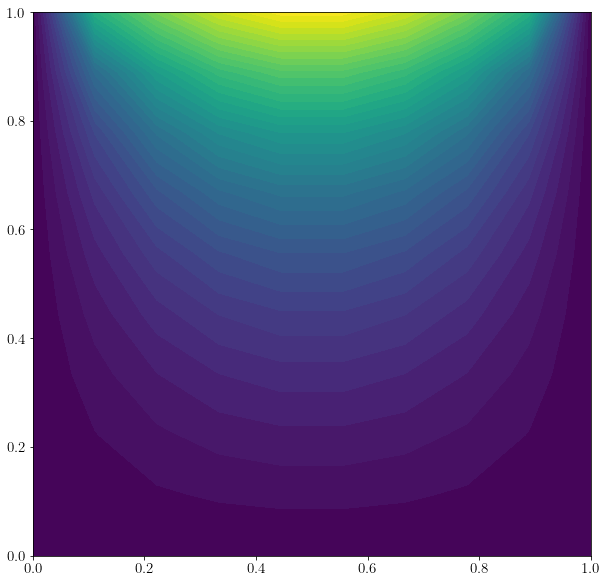

In [10]:
w = 1
h = 1

Nx = 10
Ny = 10

V0 = 10
pi = np.pi

x = np.linspace(0,w, Ny)
y = np.linspace(0,h, Nx)
xx, yy = np.meshgrid(x,y)

Vex = np.zeros(len(xx))
for k in range(100):
    Vex = Vex + (np.sin((2*k-1)*pi*xx)*np.sinh((2*k-1)*pi*yy))/((2*k -1)*np.sinh((2*k-1)*pi))

Vex = (4*V0/pi)*Vex

plt.figure(figsize=(10,10))
plt.contourf(xx, yy, Vex, levels =40)

In [11]:
# Parameters for analytical solution
e0 = 8.85e-12       # F/m
er = 1              # Relative permittivity
e = er*e0
V0 = 10              # V
rho0 = 1e-8         # C/m

In [23]:
m = 20 # Divisions in x direction
p = 20 # Divisions in y directions
NoN = (p+1)*(m+1)  # Number of Nodes
NoE = 2*p*m
NpE = 3
lx = 1 # Dimension x of problem
ly = 1 # Dimension y of problem

In [24]:
NL, EL = uniform_mesh(lx, ly, m, p, 'D2TR3N')

In [25]:
xn = NL[:,0]
yn = NL[:,1]
b = np.zeros(NoN)

alpha_y = np.zeros(NoE)
alpha_x = np.zeros(NoE)
beta = np.zeros(NoE)
ge = np.zeros(NoE)

# Cnstants for each elements
for e in range(NoE):
    alpha_x[e] = er # Permittivity in x direction
    alpha_y[e] = er # Permittivity in y direction
    beta[e] = 0
    ge[e] = 0

In [26]:
# Definition Dirichlet Boundary Conditions
EBC_nodes = []
EBC_vals = []
NBC = 0 # Number of Boundary Conditions
for i in range(NoN):
    if ((xn[i-1] == 0) or (xn[i-1] == lx) or (yn[i-1] == 0)):
        EBC_nodes.append(int(i))
        EBC_vals.append(int(0))
        NBC += 1
    elif (yn[i-1] == ly):
        EBC_nodes.append(int(i))
        EBC_vals.append(int(V0))
        NBC += 1
EBC_nodes = np.array(EBC_nodes)
EBC_vals = np.array(EBC_vals)

In [27]:
K = np.zeros([NoN, NoN])
b = np.zeros(NoN)
Me = np.zeros([3,3]) # M matrix per element
Te = np.zeros([3,3]) # T matrix per element

**Evaluación de la Matriz K**


Se empieza evaluando los elementos de la matriz $M^(e)$ cuyos elementos son:

$$
    M_{ij}^{e} = - \int\int_{\Omega}
    \left[
        \alpha_x\left(\frac{\partial N_i}{\partial x}\right)\left(\frac{\partial N_j}{\partial x}\right)
        \alpha_y\left(\frac{\partial N_i}{\partial y}\right)\left(\frac{\partial N_j}{\partial y}\right)
    \right]dxdy
$$

Las funciones base para elementos triangulares están dadas por:
$$
\begin{align*}
N_1 &= 1 - \xi -\eta\\
N_2 &= \xi \\
N_3 &= \eta
\end{align*}
$$

Las coordenadas de cualquier punto están dadas por:
$$ 
\begin{align*}
x &= x_{1}^{e} + \overline{x}_{21}\xi + \overline{x}_{31}\eta\\
x &= x_{1}^{e} + \overline{y}_{21}\xi + \overline{y}_{31}\eta
\end{align*}
$$

Aparecerá un cambio de coordenadas en los calculos

$$
\left[\begin{matrix}
\frac{\partial N}{\partial \xi} \\
\frac{\partial N}{\partial \eta} 
\end{matrix}\right] = 
\left[\begin{matrix}
\frac{\partial x}{\partial \xi} & \frac{\partial y}{\partial \xi}\\
\frac{\partial x}{\partial \eta} & \frac{\partial y}{\partial \eta}\\
\end{matrix}\right]
\left[\begin{matrix}
\frac{\partial N}{\partial x} \\
\frac{\partial N}{\partial y} 
\end{matrix}\right]
$$

$$ J = \left[\begin{matrix}
\frac{\partial x}{\partial \xi} & \frac{\partial y}{\partial \xi}\\
\frac{\partial x}{\partial \eta} & \frac{\partial y}{\partial \eta}\\
\end{matrix}\right]
$$

$$ det(J) = \overline{x}_{21}\overline{y}_{31} - \overline{x}_{31}\overline{y}_{21} = 2A_e$$

In [28]:
for e in range(NoE):
    x21 = xn[EL[e,1]-1] - xn[EL[e,0]-1]
    x31 = xn[EL[e,2]-1] - xn[EL[e,0]-1]
    x32 = xn[EL[e,2]-1] - xn[EL[e,1]-1]
    x13 = xn[EL[e,0]-1] - xn[EL[e,2]-1]
    y12 = yn[EL[e,0]-1] - yn[EL[e,1]-1]
    y21 = yn[EL[e,1]-1] - yn[EL[e,0]-1]
    y31 = yn[EL[e,2]-1] - yn[EL[e,0]-1]
    y23 = yn[EL[e,1]-1] - yn[EL[e,2]-1]
    
    # Area of constant triangular element
    Ae = 0.5*(x21*y31 - x31*y21)
    
    # Evaluation of de Me matrix
    Me[0,0] = -(alpha_x[e]*y23**2 + alpha_y[e]*x32**2)/(4*Ae)
    Me[0,1] = -(alpha_x[e]*y23*y31 + alpha_y[e]*x32*x13)/(4*Ae)
    Me[1,0] = Me[0,1]
    Me[0,2] = -(alpha_x[e]*y23*y12 + alpha_y[e]*x32*x21)/(4*Ae)
    Me[2,0] = Me[0,2]
    Me[1,1] = -(alpha_x[e]*y31**2 + alpha_y[e]*x13**2)/(4*Ae)
    Me[1,2] = -(alpha_x[e]*y31*y12 + alpha_y[e]*x13*x21)/(4*Ae)
    Me[2,1] = Me[1,2]
    Me[2,2] = -(alpha_x[e]*y12**2 + alpha_y[e]*x21**2)/(4*Ae)
    
    # Evaluation of de M matrix
    Te[0,0] = beta[e]*Ae/6
    Te[0,1] = beta[e]*Ae/12
    Te[1,0] = beta[e]*Ae/12
    Te[0,2] = beta[e]*Ae/12
    Te[2,0] = beta[e]*Ae/12
    Te[1,1] = beta[e]*Ae/6
    Te[1,2] = beta[e]*Ae/12
    Te[2,1] = beta[e]*Ae/12
    Te[2,2] = beta[e]*Ae/6

    # Me + Te = Kij
    Ke = Me + Te
    
    # Evaluation of vector g
    ge[1] = ge[e]*Ae/3
    ge[1] = ge[e]*Ae/3
    ge[1] = ge[e]*Ae/3
    
    for i in range(3):
        for j in range(3):
            K[EL[e,i]-1, EL[e,j]-1] = K[EL[e,i]-1, EL[e,j]-1] + Ke[i,j]
        
        b[EL[e,i]-1] = b[EL[e,i]-1] + ge[i]

In [29]:
# Imposition of Boundary Conditions
for i in range(NBC):
    for j in range(NoN):
        if j != EBC_nodes[i]:
            b[j] = b[j] - K[j, EBC_nodes[i]-1]*EBC_vals[i]
            
    K[:, EBC_nodes[i]-1] = 0
    K[EBC_nodes[i]-1, :] = 0
    K[EBC_nodes[i]-1, EBC_nodes[i]-1] = 1
    b[EBC_nodes[i]-1] = EBC_vals[i]

In [30]:
V = np.linalg.solve(K,b)

In [32]:
xx = NL[:,0].reshape([21,21])
yy = NL[:,1].reshape([21,21])

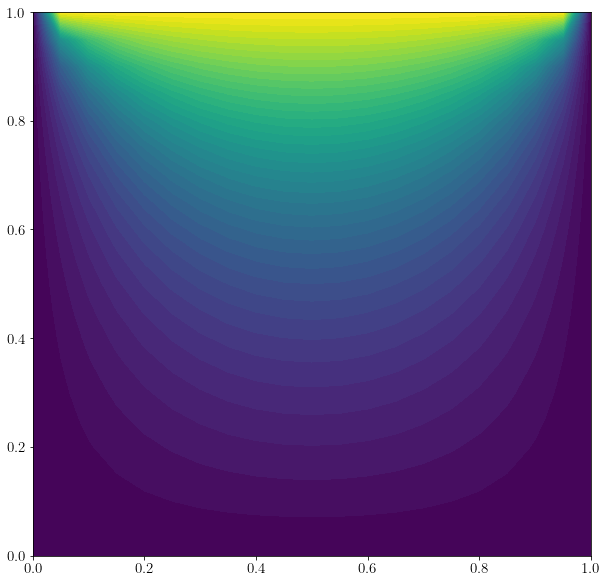

In [33]:
plt.figure(figsize=(10,10))
plt.contourf(xx,yy,V.reshape([21,21]), levels=40)

**Animación**

In [34]:
from matplotlib import animation
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib notebook

<IPython.core.display.Javascript object>


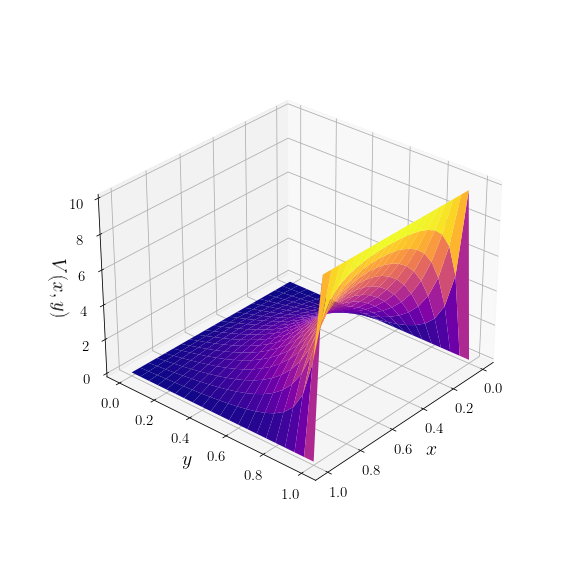

Text(0.5, 0, '$x$')

Text(0.5, 0, '$y$')

Text(0.5, 0, '$V(x, y)$')

In [37]:
fig, ax=plt.subplots(subplot_kw={"projection":"3d"}, figsize=(8,8))
ax.plot_surface(xx, yy, V.reshape([21,21]), cmap=plt.cm.plasma)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$V(x, y)$')

ax.view_init(elev=30, azim=0)

def animar(i):
    ax.view_init(elev=30, azim=i)
    
ani=animation.FuncAnimation(fig, animar, frames=120)
ani.save('3D_Surface.gif', writer='pillow', fps=240, dpi=100)

### 5. Bibliografía

1. A. Polycarpou, C Balanis -Introduction to the finite element method in electromagnetics-Morgan & Claypool Publishers (2006).
2. J. Jin, The Finite Element Method in Electromagnetics, 2nd ed. New York: Wiley-IEEE Press, 2002.